In [1]:
import warnings
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier

import optuna
from catboost import CatBoostClassifier
warnings.simplefilter('ignore', FutureWarning)

!pip install scikit-learn==1.2.2 imbalanced-learn==0.10.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 6.0 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.13.0
    Uninstalling imbalanced-learn-0.13.0:
      Successfully uninstalled imbalanced-learn-0.13.0


In [2]:
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE

In [3]:
train_df = pd.read_csv('/kaggle/input/data-split/train_split/04/train_april.csv')
test_df = pd.read_csv('/kaggle/input/data-split/train_split/04/test_april.csv')

In [4]:
X_train = train_df.drop(columns=['AWS', 'datetime', 'row','col'])
y_train = train_df['AWS']

X_test = test_df.drop(columns=['AWS', 'datetime', 'row','col'])
y_test = test_df['AWS']

## Chuẩn hóa

In [5]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

## Chọn feature

In [6]:
top_features =  ['CAPE', 'KX', 'R500', 'R850', 'TCLW', 'TCW', 'U250', 'U850', 'V250', 'V850', 'B10B', 'B11B', 'B14B', 'I2B', 'I4B', 'IRB', 'WVB']

## Hàm bổ trợ

In [7]:
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()

total = neg + pos

# Tính trọng số tỉ lệ nghịch với tần suất
w0 = total / (2 * neg) 
w1 = total / (2 * pos) 

class_weights = [w0, w1]
print(f"class_weights = {class_weights}")

class_weights = [0.5381758124391693, 7.048649105984545]


In [8]:
def print_scores(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()
    print(classification_report(y_true, y_pred))

In [9]:
def train_and_evaluate_cat(X_train, y_train, X_test, y_test, class_weights=None,  top_features=None):
    model_catboost = CatBoostClassifier(
        random_state=42,
        verbose=0,  
        class_weights=class_weights
    )

    if top_features is not None:
        X_train = X_train[top_features]
        X_test = X_test[top_features]

    model_catboost.fit(X_train, y_train)
    y_pred = model_catboost.predict(X_test)
    print_scores(y_test, y_pred)

In [10]:
def objective(trial, X_train_scaled, y_train, X_test_scaled, y_test, 
              use_smote=False, use_smoteenn=False, 
              class_weights=None, top_features=None):
    # Tối ưu các tham số cho CatBoost
    param = {
        'iterations': trial.suggest_int('iterations', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 3, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'random_strength': trial.suggest_float('random_strength', 0.1, 1.0),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'random_seed': 42,
        'verbose': 0,
        'allow_writing_files': False,
        'class_weights': class_weights if not (use_smote or use_smoteenn) else None
    }

    # Sử dụng top_features nếu được cung cấp
    if top_features is not None:
        X_train_scaled = X_train_scaled[top_features]
        X_test_scaled = X_test_scaled[top_features]

    model = CatBoostClassifier(**param)
    model.fit(X_train_scaled, y_train)

    # Dự đoán và tối ưu threshold
    y_probs = model.predict_proba(X_test_scaled)[:, 1]
    best_thresh = trial.suggest_float('threshold', 0.1, 0.9, step=0.05)
    y_pred = (y_probs >= best_thresh).astype(int)

    return f1_score(y_test, y_pred, pos_label=1)


In [11]:
def optimize_and_train_catboost(X_train, y_train, X_test, y_test,
                                use_smote=False, use_smoteenn=False,
                                class_weights=None, top_features=None,
                                n_trials=50):
    study = optuna.create_study(direction='maximize')

    # Tối ưu hóa tham số
    study.optimize(lambda trial: objective(
                        trial, X_train, y_train, X_test, y_test,
                        use_smote, use_smoteenn, class_weights, top_features),
                   n_trials=n_trials)

    # In kết quả tốt nhất
    print("Best trial:")
    print(study.best_trial)
    print("Best hyperparameters:")
    for key, value in study.best_trial.params.items():
        print(f"{key}: {value}")

    # Huấn luyện lại với tham số tốt nhất
    best_params = study.best_trial.params
    best_thresh = best_params.pop('threshold')

    best_params.update({
        'random_seed': 42,
        'verbose': 0,
        'loss_function': 'Logloss',
        'eval_metric': 'F1'
    })

    if class_weights:
        best_params['class_weights'] = class_weights

    best_model = CatBoostClassifier(**best_params)

    # Chọn đặc trưng nếu có
    if top_features is not None:
        X_train_use = X_train[top_features]
        X_test_use = X_test[top_features]
    else:
        X_train_use = X_train
        X_test_use = X_test

    best_model.fit(X_train_use, y_train)
    y_probs = best_model.predict_proba(X_test_use)[:, 1]
    y_pred_thresh = (y_probs >= best_thresh).astype(int)

    print(f"Best threshold: {best_thresh}")
    print_scores(y_test, y_pred_thresh)


# Không SMOTE

## Data

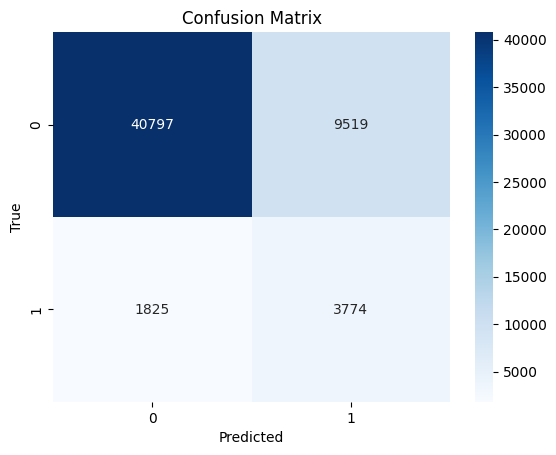

              precision    recall  f1-score   support

           0       0.96      0.81      0.88     50316
           1       0.28      0.67      0.40      5599

    accuracy                           0.80     55915
   macro avg       0.62      0.74      0.64     55915
weighted avg       0.89      0.80      0.83     55915



In [12]:
train_and_evaluate_cat(X_train_scaled, y_train, X_test_scaled, y_test,  class_weights=class_weights)

## Data tune

[I 2025-05-05 19:28:01,388] A new study created in memory with name: no-name-abbaa531-40e6-4256-86a1-1769e06cb5ba
[I 2025-05-05 19:28:13,219] Trial 0 finished with value: 0.34709528311797455 and parameters: {'iterations': 381, 'learning_rate': 0.016859023255348035, 'depth': 3, 'l2_leaf_reg': 3.9122319091454854, 'random_strength': 0.6711774909734529, 'bagging_temperature': 0.029935239026473992, 'threshold': 0.1}. Best is trial 0 with value: 0.34709528311797455.
[I 2025-05-05 19:28:24,603] Trial 1 finished with value: 0.33417338709677424 and parameters: {'iterations': 192, 'learning_rate': 0.13192411693085526, 'depth': 8, 'l2_leaf_reg': 7.464279445194295, 'random_strength': 0.4746966703970522, 'bagging_temperature': 0.43999481560455744, 'threshold': 0.6}. Best is trial 0 with value: 0.34709528311797455.
[I 2025-05-05 19:28:37,766] Trial 2 finished with value: 0.1417374265186153 and parameters: {'iterations': 306, 'learning_rate': 0.06469385279138652, 'depth': 6, 'l2_leaf_reg': 7.77178574

Best trial:
FrozenTrial(number=27, state=1, values=[0.45561393805309736], datetime_start=datetime.datetime(2025, 5, 5, 19, 33, 0, 759536), datetime_complete=datetime.datetime(2025, 5, 5, 19, 33, 5, 791995), params={'iterations': 130, 'learning_rate': 0.09476740006799178, 'depth': 5, 'l2_leaf_reg': 3.7390504866743863, 'random_strength': 0.8430552147266269, 'bagging_temperature': 0.6064736851164019, 'threshold': 0.30000000000000004}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'iterations': IntDistribution(high=500, log=False, low=100, step=1), 'learning_rate': FloatDistribution(high=0.3, log=False, low=0.01, step=None), 'depth': IntDistribution(high=10, log=False, low=3, step=1), 'l2_leaf_reg': FloatDistribution(high=10.0, log=False, low=1.0, step=None), 'random_strength': FloatDistribution(high=1.0, log=False, low=0.1, step=None), 'bagging_temperature': FloatDistribution(high=1.0, log=False, low=0.0, step=None), 'threshold': FloatDistribution(high=0.9, log=Fa

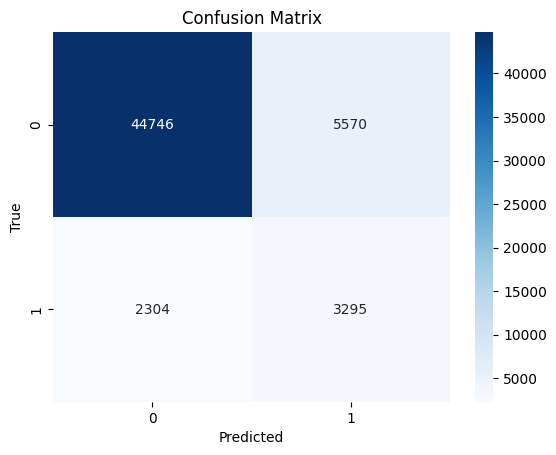

              precision    recall  f1-score   support

           0       0.95      0.89      0.92     50316
           1       0.37      0.59      0.46      5599

    accuracy                           0.86     55915
   macro avg       0.66      0.74      0.69     55915
weighted avg       0.89      0.86      0.87     55915



In [13]:
optimize_and_train_catboost(X_train_scaled, y_train, X_test_scaled, y_test)

## Data + feature

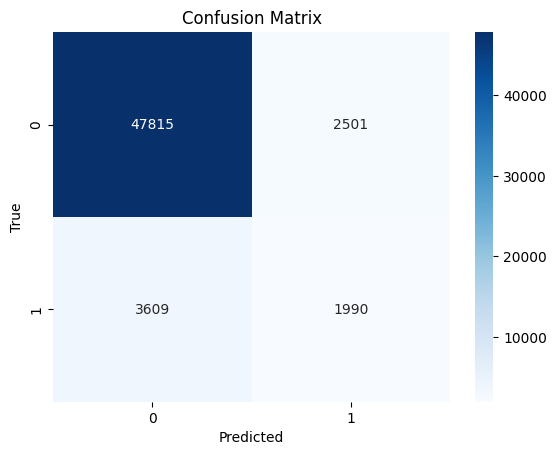

              precision    recall  f1-score   support

           0       0.93      0.95      0.94     50316
           1       0.44      0.36      0.39      5599

    accuracy                           0.89     55915
   macro avg       0.69      0.65      0.67     55915
weighted avg       0.88      0.89      0.89     55915



In [14]:
train_and_evaluate_cat(X_train_scaled, y_train, X_test_scaled, y_test, top_features=top_features)

## Data + Feature + Tune

[I 2025-05-05 19:38:32,326] A new study created in memory with name: no-name-e3edc456-e5bf-4579-b51b-83e63deb44c1
[I 2025-05-05 19:38:43,324] Trial 0 finished with value: 0.42509511162156344 and parameters: {'iterations': 349, 'learning_rate': 0.04755594823432547, 'depth': 5, 'l2_leaf_reg': 4.591408180057078, 'random_strength': 0.8575790978621218, 'bagging_temperature': 0.7752810899475245, 'threshold': 0.35}. Best is trial 0 with value: 0.42509511162156344.
[I 2025-05-05 19:38:49,464] Trial 1 finished with value: 0.35443633796187335 and parameters: {'iterations': 243, 'learning_rate': 0.22456933583802355, 'depth': 3, 'l2_leaf_reg': 5.847294331698978, 'random_strength': 0.783018316615545, 'bagging_temperature': 0.6864097972334211, 'threshold': 0.6}. Best is trial 0 with value: 0.42509511162156344.
[I 2025-05-05 19:38:52,637] Trial 2 finished with value: 0.0 and parameters: {'iterations': 172, 'learning_rate': 0.029681099470654136, 'depth': 4, 'l2_leaf_reg': 2.671426311289269, 'random_st

Best trial:
FrozenTrial(number=32, state=1, values=[0.4280985062575696], datetime_start=datetime.datetime(2025, 5, 5, 19, 46, 36, 202496), datetime_complete=datetime.datetime(2025, 5, 5, 19, 46, 47, 572171), params={'iterations': 469, 'learning_rate': 0.18915055848882717, 'depth': 3, 'l2_leaf_reg': 3.511572755460964, 'random_strength': 0.9566281127501658, 'bagging_temperature': 0.6799705547971013, 'threshold': 0.35}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'iterations': IntDistribution(high=500, log=False, low=100, step=1), 'learning_rate': FloatDistribution(high=0.3, log=False, low=0.01, step=None), 'depth': IntDistribution(high=10, log=False, low=3, step=1), 'l2_leaf_reg': FloatDistribution(high=10.0, log=False, low=1.0, step=None), 'random_strength': FloatDistribution(high=1.0, log=False, low=0.1, step=None), 'bagging_temperature': FloatDistribution(high=1.0, log=False, low=0.0, step=None), 'threshold': FloatDistribution(high=0.9, log=False, low=0.1, s

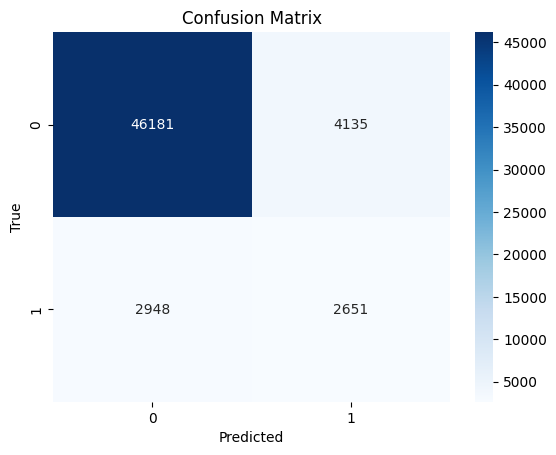

              precision    recall  f1-score   support

           0       0.94      0.92      0.93     50316
           1       0.39      0.47      0.43      5599

    accuracy                           0.87     55915
   macro avg       0.67      0.70      0.68     55915
weighted avg       0.88      0.87      0.88     55915



In [15]:
optimize_and_train_catboost(X_train_scaled, y_train, X_test_scaled, y_test, top_features=top_features)

## Data + class_weights

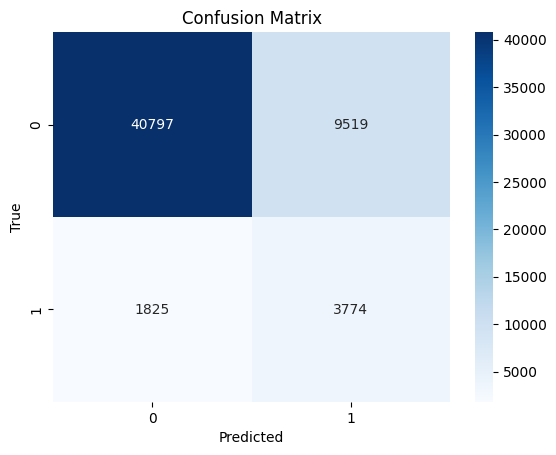

              precision    recall  f1-score   support

           0       0.96      0.81      0.88     50316
           1       0.28      0.67      0.40      5599

    accuracy                           0.80     55915
   macro avg       0.62      0.74      0.64     55915
weighted avg       0.89      0.80      0.83     55915



In [16]:
train_and_evaluate_cat(X_train_scaled, y_train, X_test_scaled, y_test, class_weights=class_weights)

## Data + class_weights + Tune

[I 2025-05-05 19:50:53,826] A new study created in memory with name: no-name-449d5e71-486e-4158-ac98-e54ddb44b495
[I 2025-05-05 19:51:52,570] Trial 0 finished with value: 0.4119778752622544 and parameters: {'iterations': 381, 'learning_rate': 0.13525550997385613, 'depth': 10, 'l2_leaf_reg': 2.6589328927797253, 'random_strength': 0.9588229673816371, 'bagging_temperature': 0.47794217726906396, 'threshold': 0.45000000000000007}. Best is trial 0 with value: 0.4119778752622544.
[I 2025-05-05 19:52:04,848] Trial 1 finished with value: 0.3357056618161022 and parameters: {'iterations': 264, 'learning_rate': 0.06652056831575595, 'depth': 6, 'l2_leaf_reg': 5.219222151259624, 'random_strength': 0.3861645186181807, 'bagging_temperature': 0.6553394235081613, 'threshold': 0.35}. Best is trial 0 with value: 0.4119778752622544.
[I 2025-05-05 19:52:16,914] Trial 2 finished with value: 0.41856555846096377 and parameters: {'iterations': 239, 'learning_rate': 0.17280924340851628, 'depth': 7, 'l2_leaf_reg'

Best trial:
FrozenTrial(number=24, state=1, values=[0.4463370816421585], datetime_start=datetime.datetime(2025, 5, 5, 19, 57, 28, 473307), datetime_complete=datetime.datetime(2025, 5, 5, 19, 57, 35, 590530), params={'iterations': 235, 'learning_rate': 0.21823299656650091, 'depth': 3, 'l2_leaf_reg': 6.324665923712574, 'random_strength': 0.923396752677971, 'bagging_temperature': 0.10648019899785405, 'threshold': 0.8}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'iterations': IntDistribution(high=500, log=False, low=100, step=1), 'learning_rate': FloatDistribution(high=0.3, log=False, low=0.01, step=None), 'depth': IntDistribution(high=10, log=False, low=3, step=1), 'l2_leaf_reg': FloatDistribution(high=10.0, log=False, low=1.0, step=None), 'random_strength': FloatDistribution(high=1.0, log=False, low=0.1, step=None), 'bagging_temperature': FloatDistribution(high=1.0, log=False, low=0.0, step=None), 'threshold': FloatDistribution(high=0.9, log=False, low=0.1, st

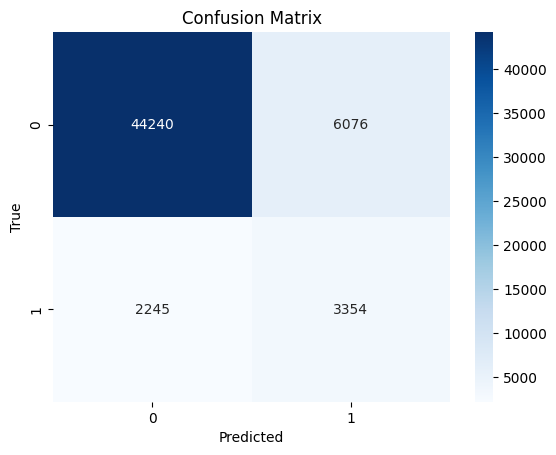

              precision    recall  f1-score   support

           0       0.95      0.88      0.91     50316
           1       0.36      0.60      0.45      5599

    accuracy                           0.85     55915
   macro avg       0.65      0.74      0.68     55915
weighted avg       0.89      0.85      0.87     55915



In [17]:
optimize_and_train_catboost(X_train_scaled, y_train, X_test_scaled, y_test,class_weights=class_weights)

## Data + class_weights + feature 

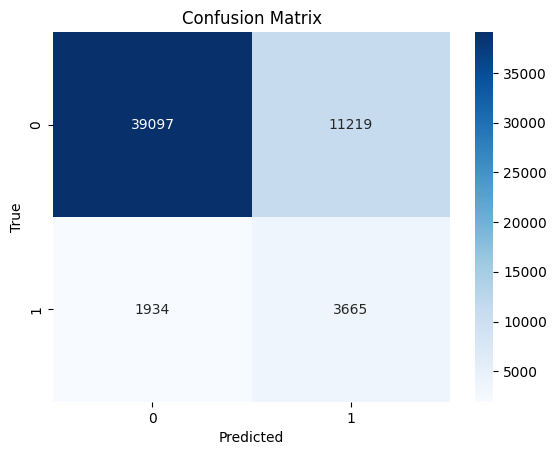

              precision    recall  f1-score   support

           0       0.95      0.78      0.86     50316
           1       0.25      0.65      0.36      5599

    accuracy                           0.76     55915
   macro avg       0.60      0.72      0.61     55915
weighted avg       0.88      0.76      0.81     55915



In [18]:
train_and_evaluate_cat(X_train_scaled, y_train, X_test_scaled, y_test, class_weights=class_weights, top_features=top_features)

## Data + class_weights + feature + tune

[I 2025-05-05 20:03:08,940] A new study created in memory with name: no-name-a057fb72-373e-4f93-a6c4-5ad97abbe932
[I 2025-05-05 20:03:31,722] Trial 0 finished with value: 0.3912206940782441 and parameters: {'iterations': 461, 'learning_rate': 0.207329414990523, 'depth': 8, 'l2_leaf_reg': 5.900770100292032, 'random_strength': 0.42025679384544457, 'bagging_temperature': 0.9525742634589965, 'threshold': 0.65}. Best is trial 0 with value: 0.3912206940782441.
[I 2025-05-05 20:03:39,243] Trial 1 finished with value: 0.33352675693101225 and parameters: {'iterations': 252, 'learning_rate': 0.14046456538128904, 'depth': 4, 'l2_leaf_reg': 5.192708059408159, 'random_strength': 0.5390167489813096, 'bagging_temperature': 0.7107286673573444, 'threshold': 0.4}. Best is trial 0 with value: 0.3912206940782441.
[I 2025-05-05 20:03:47,236] Trial 2 finished with value: 0.4134825991725481 and parameters: {'iterations': 175, 'learning_rate': 0.05477297608795645, 'depth': 9, 'l2_leaf_reg': 6.879982377636158,

Best trial:
FrozenTrial(number=47, state=1, values=[0.42979271577468087], datetime_start=datetime.datetime(2025, 5, 5, 20, 11, 16, 121424), datetime_complete=datetime.datetime(2025, 5, 5, 20, 11, 20, 180664), params={'iterations': 171, 'learning_rate': 0.04748362916564959, 'depth': 4, 'l2_leaf_reg': 9.380803439478727, 'random_strength': 0.9668225473723667, 'bagging_temperature': 0.4268672922316357, 'threshold': 0.8}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'iterations': IntDistribution(high=500, log=False, low=100, step=1), 'learning_rate': FloatDistribution(high=0.3, log=False, low=0.01, step=None), 'depth': IntDistribution(high=10, log=False, low=3, step=1), 'l2_leaf_reg': FloatDistribution(high=10.0, log=False, low=1.0, step=None), 'random_strength': FloatDistribution(high=1.0, log=False, low=0.1, step=None), 'bagging_temperature': FloatDistribution(high=1.0, log=False, low=0.0, step=None), 'threshold': FloatDistribution(high=0.9, log=False, low=0.1, s

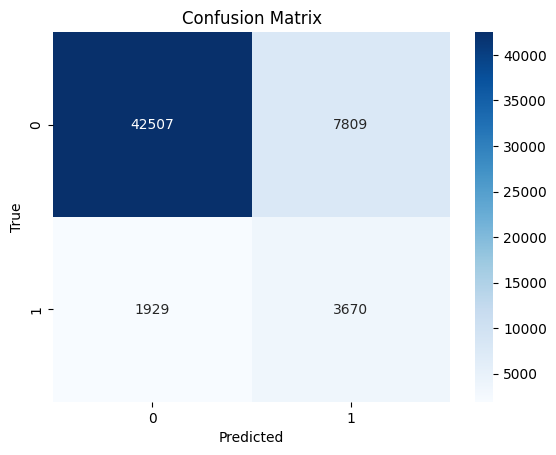

              precision    recall  f1-score   support

           0       0.96      0.84      0.90     50316
           1       0.32      0.66      0.43      5599

    accuracy                           0.83     55915
   macro avg       0.64      0.75      0.66     55915
weighted avg       0.89      0.83      0.85     55915



In [19]:
optimize_and_train_catboost(X_train_scaled, y_train, X_test_scaled, y_test,class_weights=class_weights, top_features = top_features)

# SMOTE

In [20]:
sm = SMOTE()

X_sm, y_sm = sm.fit_resample(X_train, y_train)
X_sm.shape, y_sm.shape

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_sm)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

## Data SMOTE 

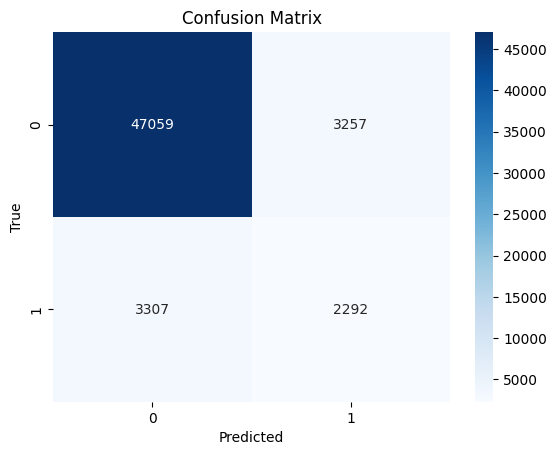

              precision    recall  f1-score   support

           0       0.93      0.94      0.93     50316
           1       0.41      0.41      0.41      5599

    accuracy                           0.88     55915
   macro avg       0.67      0.67      0.67     55915
weighted avg       0.88      0.88      0.88     55915



In [21]:
train_and_evaluate_cat(X_train_scaled, y_sm, X_test_scaled, y_test)

## Data SMOTE + Tune

[I 2025-05-05 20:12:57,387] A new study created in memory with name: no-name-97bfc615-058c-4f90-9b4d-95c2ab05d9ff
[I 2025-05-05 20:13:23,626] Trial 0 finished with value: 0.4458777999296352 and parameters: {'iterations': 415, 'learning_rate': 0.14037394551667234, 'depth': 4, 'l2_leaf_reg': 7.38593632009236, 'random_strength': 0.7435069243616993, 'bagging_temperature': 0.8073430268321827, 'threshold': 0.45000000000000007}. Best is trial 0 with value: 0.4458777999296352.
[I 2025-05-05 20:13:35,977] Trial 1 finished with value: 0.2791806958473625 and parameters: {'iterations': 177, 'learning_rate': 0.10955923170579622, 'depth': 4, 'l2_leaf_reg': 2.9150799107376195, 'random_strength': 0.99700477412, 'bagging_temperature': 0.5348205876073084, 'threshold': 0.85}. Best is trial 0 with value: 0.4458777999296352.
[I 2025-05-05 20:13:48,735] Trial 2 finished with value: 0.28405048615319756 and parameters: {'iterations': 207, 'learning_rate': 0.19196118818762126, 'depth': 4, 'l2_leaf_reg': 8.9774

Best trial:
FrozenTrial(number=39, state=1, values=[0.46222985922939663], datetime_start=datetime.datetime(2025, 5, 5, 20, 31, 23, 509534), datetime_complete=datetime.datetime(2025, 5, 5, 20, 31, 39, 103383), params={'iterations': 251, 'learning_rate': 0.16021257451494003, 'depth': 4, 'l2_leaf_reg': 7.943266882041006, 'random_strength': 0.42991609851077256, 'bagging_temperature': 0.9406900803999166, 'threshold': 0.55}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'iterations': IntDistribution(high=500, log=False, low=100, step=1), 'learning_rate': FloatDistribution(high=0.3, log=False, low=0.01, step=None), 'depth': IntDistribution(high=10, log=False, low=3, step=1), 'l2_leaf_reg': FloatDistribution(high=10.0, log=False, low=1.0, step=None), 'random_strength': FloatDistribution(high=1.0, log=False, low=0.1, step=None), 'bagging_temperature': FloatDistribution(high=1.0, log=False, low=0.0, step=None), 'threshold': FloatDistribution(high=0.9, log=False, low=0.1,

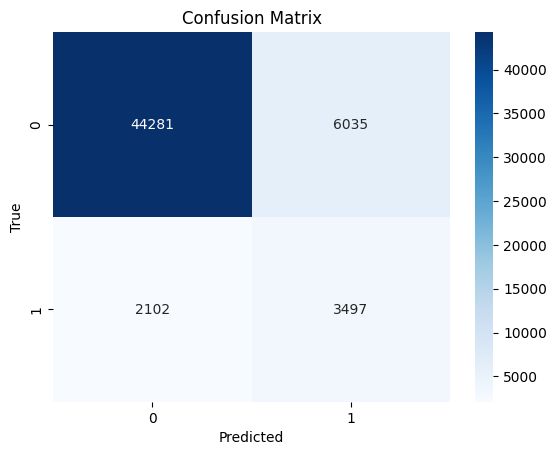

              precision    recall  f1-score   support

           0       0.95      0.88      0.92     50316
           1       0.37      0.62      0.46      5599

    accuracy                           0.85     55915
   macro avg       0.66      0.75      0.69     55915
weighted avg       0.90      0.85      0.87     55915



In [22]:
optimize_and_train_catboost(X_train_scaled, y_sm, X_test_scaled, y_test, use_smote=True)

## Data SMOTE + Feature

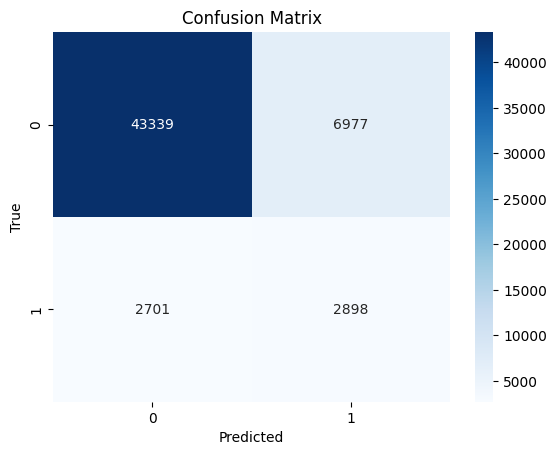

              precision    recall  f1-score   support

           0       0.94      0.86      0.90     50316
           1       0.29      0.52      0.37      5599

    accuracy                           0.83     55915
   macro avg       0.62      0.69      0.64     55915
weighted avg       0.88      0.83      0.85     55915



In [23]:
train_and_evaluate_cat(X_train_scaled, y_sm, X_test_scaled, y_test, top_features = top_features)

## Data SMOTE + Feature + Tune

[I 2025-05-05 20:35:15,365] A new study created in memory with name: no-name-6bfb7490-1d91-415d-98af-16e6444ff6d1
[I 2025-05-05 20:35:37,561] Trial 0 finished with value: 0.2976409524071074 and parameters: {'iterations': 215, 'learning_rate': 0.01091546065864362, 'depth': 9, 'l2_leaf_reg': 3.852559652976356, 'random_strength': 0.32032007139824314, 'bagging_temperature': 0.23224048961898236, 'threshold': 0.30000000000000004}. Best is trial 0 with value: 0.2976409524071074.
[I 2025-05-05 20:35:44,009] Trial 1 finished with value: 0.36771779796900056 and parameters: {'iterations': 189, 'learning_rate': 0.08802663906752156, 'depth': 4, 'l2_leaf_reg': 5.504487463299502, 'random_strength': 0.9781479292187092, 'bagging_temperature': 0.0945171493348903, 'threshold': 0.85}. Best is trial 1 with value: 0.36771779796900056.
[I 2025-05-05 20:35:50,009] Trial 2 finished with value: 0.3760818253343824 and parameters: {'iterations': 100, 'learning_rate': 0.21729634147966329, 'depth': 8, 'l2_leaf_reg'

Best trial:
FrozenTrial(number=35, state=1, values=[0.4430439155212873], datetime_start=datetime.datetime(2025, 5, 5, 20, 46, 46, 347), datetime_complete=datetime.datetime(2025, 5, 5, 20, 46, 55, 834848), params={'iterations': 213, 'learning_rate': 0.07599538089347807, 'depth': 3, 'l2_leaf_reg': 9.971981000770384, 'random_strength': 0.3514589251015193, 'bagging_temperature': 0.9385446689891392, 'threshold': 0.75}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'iterations': IntDistribution(high=500, log=False, low=100, step=1), 'learning_rate': FloatDistribution(high=0.3, log=False, low=0.01, step=None), 'depth': IntDistribution(high=10, log=False, low=3, step=1), 'l2_leaf_reg': FloatDistribution(high=10.0, log=False, low=1.0, step=None), 'random_strength': FloatDistribution(high=1.0, log=False, low=0.1, step=None), 'bagging_temperature': FloatDistribution(high=1.0, log=False, low=0.0, step=None), 'threshold': FloatDistribution(high=0.9, log=False, low=0.1, step

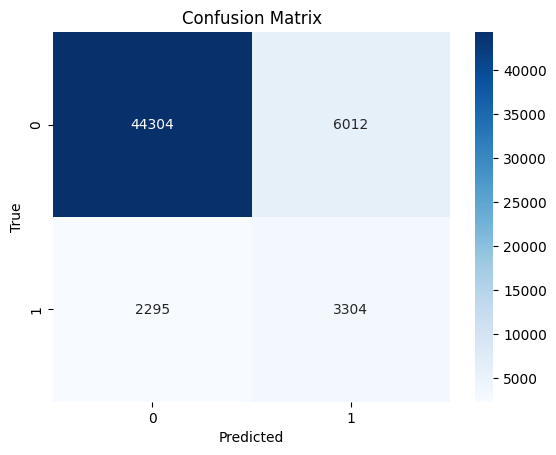

              precision    recall  f1-score   support

           0       0.95      0.88      0.91     50316
           1       0.35      0.59      0.44      5599

    accuracy                           0.85     55915
   macro avg       0.65      0.74      0.68     55915
weighted avg       0.89      0.85      0.87     55915



In [24]:
optimize_and_train_catboost(X_train_scaled, y_sm, X_test_scaled, y_test, top_features=top_features, use_smote = True)

# SMOTE ENN

In [25]:
smenn = SMOTEENN()

X_smenn, y_smenn = smenn.fit_resample(X_train, y_train)
X_smenn.shape, y_sm.shape

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_smenn)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

## Data SMOTE ENN 

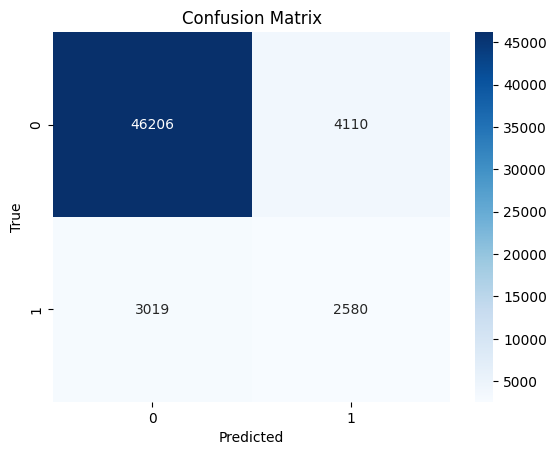

              precision    recall  f1-score   support

           0       0.94      0.92      0.93     50316
           1       0.39      0.46      0.42      5599

    accuracy                           0.87     55915
   macro avg       0.66      0.69      0.67     55915
weighted avg       0.88      0.87      0.88     55915



In [26]:
train_and_evaluate_cat(X_train_scaled, y_smenn, X_test_scaled, y_test)

## Data SMOTE ENN + Tune

[I 2025-05-05 21:01:17,077] A new study created in memory with name: no-name-57078e27-f0f5-4b5b-bcb0-f34ec7a02730
[I 2025-05-05 21:01:50,753] Trial 0 finished with value: 0.3953910923997341 and parameters: {'iterations': 313, 'learning_rate': 0.03903787891321445, 'depth': 9, 'l2_leaf_reg': 5.448940610333986, 'random_strength': 0.6496328294873227, 'bagging_temperature': 0.3546866458128597, 'threshold': 0.4}. Best is trial 0 with value: 0.3953910923997341.
[I 2025-05-05 21:02:09,712] Trial 1 finished with value: 0.4020394590999778 and parameters: {'iterations': 430, 'learning_rate': 0.15570431197837675, 'depth': 3, 'l2_leaf_reg': 2.1668704200849684, 'random_strength': 0.8038803235946627, 'bagging_temperature': 0.4183200663145076, 'threshold': 0.35}. Best is trial 1 with value: 0.4020394590999778.
[I 2025-05-05 21:03:33,851] Trial 2 finished with value: 0.38231098430813126 and parameters: {'iterations': 402, 'learning_rate': 0.216843291760415, 'depth': 10, 'l2_leaf_reg': 4.46745769916386,

Best trial:
FrozenTrial(number=49, state=1, values=[0.4719759689354531], datetime_start=datetime.datetime(2025, 5, 5, 21, 18, 47, 123476), datetime_complete=datetime.datetime(2025, 5, 5, 21, 19, 7, 70977), params={'iterations': 424, 'learning_rate': 0.23472900662307233, 'depth': 3, 'l2_leaf_reg': 6.300285930745067, 'random_strength': 0.8863504360315755, 'bagging_temperature': 0.07251995420518192, 'threshold': 0.65}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'iterations': IntDistribution(high=500, log=False, low=100, step=1), 'learning_rate': FloatDistribution(high=0.3, log=False, low=0.01, step=None), 'depth': IntDistribution(high=10, log=False, low=3, step=1), 'l2_leaf_reg': FloatDistribution(high=10.0, log=False, low=1.0, step=None), 'random_strength': FloatDistribution(high=1.0, log=False, low=0.1, step=None), 'bagging_temperature': FloatDistribution(high=1.0, log=False, low=0.0, step=None), 'threshold': FloatDistribution(high=0.9, log=False, low=0.1, st

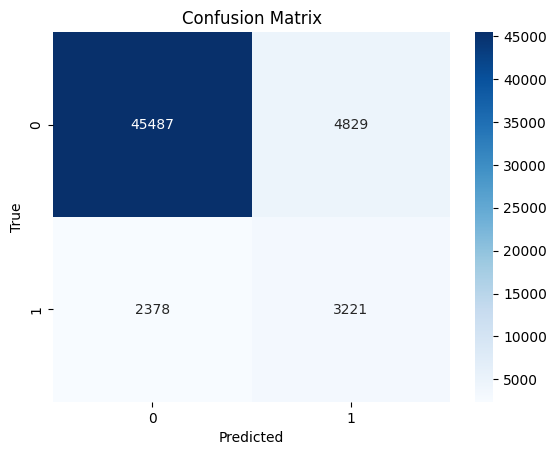

              precision    recall  f1-score   support

           0       0.95      0.90      0.93     50316
           1       0.40      0.58      0.47      5599

    accuracy                           0.87     55915
   macro avg       0.68      0.74      0.70     55915
weighted avg       0.90      0.87      0.88     55915



In [27]:
optimize_and_train_catboost(X_train_scaled, y_smenn, X_test_scaled, y_test, use_smoteenn = True)

## Data SMOTE ENN + Feature

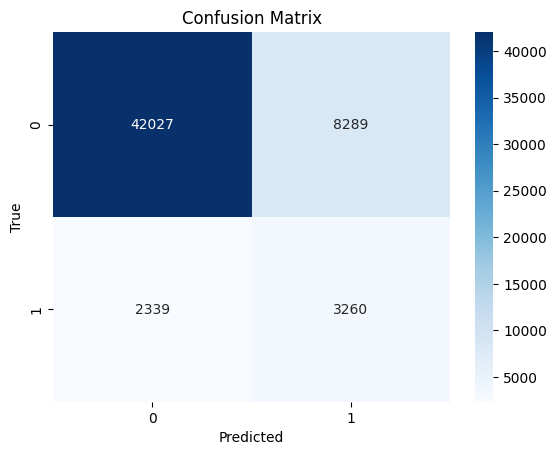

              precision    recall  f1-score   support

           0       0.95      0.84      0.89     50316
           1       0.28      0.58      0.38      5599

    accuracy                           0.81     55915
   macro avg       0.61      0.71      0.63     55915
weighted avg       0.88      0.81      0.84     55915



In [28]:
train_and_evaluate_cat(X_train_scaled, y_smenn, X_test_scaled, y_test, top_features = top_features)

## Data SMOTE ENN + Feature + Tune

[I 2025-05-05 21:20:20,635] A new study created in memory with name: no-name-4832293a-2e30-40dd-aad4-1612d68ec2f6
[I 2025-05-05 21:20:28,407] Trial 0 finished with value: 0.39009579199452626 and parameters: {'iterations': 188, 'learning_rate': 0.02112766933853057, 'depth': 7, 'l2_leaf_reg': 7.602624501685132, 'random_strength': 0.3500255709361342, 'bagging_temperature': 0.5672680483156465, 'threshold': 0.65}. Best is trial 0 with value: 0.39009579199452626.
[I 2025-05-05 21:20:43,137] Trial 1 finished with value: 0.3857702832630723 and parameters: {'iterations': 307, 'learning_rate': 0.2240530440422427, 'depth': 5, 'l2_leaf_reg': 9.980479423840563, 'random_strength': 0.8441689057943577, 'bagging_temperature': 0.47830631821691183, 'threshold': 0.7000000000000001}. Best is trial 0 with value: 0.39009579199452626.
[I 2025-05-05 21:21:12,298] Trial 2 finished with value: 0.3622703648433078 and parameters: {'iterations': 201, 'learning_rate': 0.1006012166688161, 'depth': 10, 'l2_leaf_reg': 

Best trial:
FrozenTrial(number=48, state=1, values=[0.41948605062927685], datetime_start=datetime.datetime(2025, 5, 5, 21, 32, 23, 929000), datetime_complete=datetime.datetime(2025, 5, 5, 21, 32, 38, 765251), params={'iterations': 397, 'learning_rate': 0.04188843534765833, 'depth': 3, 'l2_leaf_reg': 8.45072903525421, 'random_strength': 0.12294541122861902, 'bagging_temperature': 0.5838833665203722, 'threshold': 0.65}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'iterations': IntDistribution(high=500, log=False, low=100, step=1), 'learning_rate': FloatDistribution(high=0.3, log=False, low=0.01, step=None), 'depth': IntDistribution(high=10, log=False, low=3, step=1), 'l2_leaf_reg': FloatDistribution(high=10.0, log=False, low=1.0, step=None), 'random_strength': FloatDistribution(high=1.0, log=False, low=0.1, step=None), 'bagging_temperature': FloatDistribution(high=1.0, log=False, low=0.0, step=None), 'threshold': FloatDistribution(high=0.9, log=False, low=0.1, 

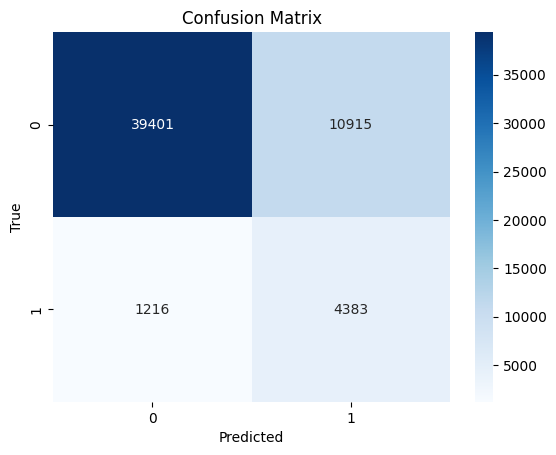

              precision    recall  f1-score   support

           0       0.97      0.78      0.87     50316
           1       0.29      0.78      0.42      5599

    accuracy                           0.78     55915
   macro avg       0.63      0.78      0.64     55915
weighted avg       0.90      0.78      0.82     55915



In [29]:
optimize_and_train_catboost(X_train_scaled, y_smenn, X_test_scaled, y_test, top_features=top_features,  use_smoteenn = True)